<a href="https://colab.research.google.com/github/am4279/Yelp_Sentiment_Models/blob/main/Yelp_BiGRU_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Building the Yelp Sentiment Model

## Data Prep

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!tar -xvf  '/content/drive/My Drive/yelp_dataset.tar' #-C 'content/drive/My Drive/yelp_reviews'

In [2]:
import pandas as pd

# DATA_PATH = '/content/drive/MyDrive/yelp_academic_dataset_review.json'
# data = pd.read_json(DATA_PATH, orient='records', lines=True)
# data.shape

### Initializing a Spark kernel to operate on a file this size

In [ ]:
!pip install pyspark
!pip install langdetect

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import numpy as np

In [ ]:
from langdetect import detect

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:
!wget -q https://mirror.cogentco.com/pub/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz


In [ ]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz


In [ ]:
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [ ]:
review = spark.read.json('/content/drive/MyDrive/yelp_academic_dataset_review.json')

In [ ]:
review.count()

In [ ]:
review.head(10)

[Row(business_id='buF9druCkbuXLX526sGELQ', cool=1, date='2014-10-11 03:34:02', funny=1, review_id='lWC-xP3rd6obsecCYsGZRg', stars=4.0, text="Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and gran

In [ ]:
review_sample.printSchema()

In [ ]:
review_sample.describe(['stars']).show()

In [ ]:
review_sample.groupby('stars').agg(count('*').alias('record_cnt')).orderBy('stars', ascending=False).show()

In [ ]:
review = review.\
withColumn("sentiment_strength",\
           when(col("stars") == 1, "Strong Negative").\
           when(col("stars") == 2, "Negative").\
           when(col("stars") == 3, "Neutral").\
           when(col("stars") == 4, "Positive").\
           when(col("stars") == 5, "Strong Positive").\
           otherwise("No Sentiment")).\
withColumn("label",\
           when(col("stars") == 1, 0).\
#            when(col("stars") == 2, 0).\
#            when(col("stars") == 3, 2).\
#            when(col("stars") == 4, 1).\
           when(col("stars") == 5, 1).\
           otherwise(3))

In [ ]:
review.groupby('label').agg(count('*').alias('record_cnt')).orderBy('label', ascending=False).show()

+-----+----------+
|label|record_cnt|
+-----+----------+
|    3|   3558071|
|    1|   3814532|
|    0|   1262800|
+-----+----------+



In [ ]:
trainingData = review.filter(review['label'] < 3).select('text', 'label')

In [ ]:
trainingData.limit(5)

text,label
I called WVM on t...,1
This place used t...,0
Probably one of t...,1
I work in the Pru...,1
They NEVER seem t...,0


### Balance sample between classes

In [ ]:
ratio_adjust = 1.0 ## ratio of pos to neg in the df_subsample


counts = trainingData.groupBy('label').count().collect()

if counts[0][1] > counts[1][1]:
    down_class = counts[0][0]
else:
    down_class = counts[1][0]
    

higherBound = counts[0][1]
treshold_to_filter = int(ratio_adjust * float(counts[1][1]) / counts[0][1] * higherBound)
 
randGen = lambda x: np.random.randint(0, higherBound) if x == down_class else -1
 
udfRandGen = udf(randGen, IntegerType())

trainingData = trainingData.withColumn("randIndex", udfRandGen("label"))
trainingData = trainingData.filter(trainingData['randIndex'] < treshold_to_filter).drop('randIndex')
 
print("Distribution of Pos and Neg cases of the down-sampled training data are: \n", \
      trainingData.groupBy("label").count().take(3))

Distribution of Pos and Neg cases of the down-sampled training data are: 
 [Row(label=1, count=1262267), Row(label=0, count=1262800)]


In [ ]:
trainingDataSample = trainingData.sample(False, 0.1, 12345)

In [ ]:
trainingDataSample.count()

251744

In [ ]:
pd_reviews = trainingDataSample.toPandas()
type(pd_reviews)

pandas.core.frame.DataFrame

In [ ]:
# pd_reviews.to_pickle('/temp/yelp_review.pkl')

pd_reviews.to_json('/content/drive/MyDrive/yelp_review.json', orient='records', lines=True)

In [ ]:
pd_reviews.head(5)

,text,label
0,"This place used to be a cool, chill place. Now...",0
1,best pizza on a busy street! my kids love it. ...,1
2,"Seriously, why aren't you at Comfort?\n\nTonig...",1
3,A few months back i went in for a toothache an...,0
4,"Might be helpful if you were looking to buy, b...",0


In [ ]:
pd_reviews.shape

(251784, 2)

#### Saving the review DF with star ratings for multi-class classification

In [ ]:
review_sample = review.sample(False, 0.05, 12345)
review_sample.count()

432079

In [ ]:
pd_stars = review_sample.select('text', 'sentiment_strength').toPandas()

In [ ]:
# pd_stars.to_pickle('/temp/yelp_review_stars.pkl')

pd_stars.to_json('/content/drive/MyDrive/yelp_review_stars.json', orient='records', lines=True)

In [ ]:
pd_stars.head(5)

,text,sentiment_strength
0,This store is pretty good. Not as great as Wal...,Positive
1,"They NEVER seem to get our \norder correct, se...",Strong Negative
2,This place is truly a hidden gem (literally hi...,Positive
3,Incredible donuts. Sometimes you have to go ea...,Strong Positive
4,The ramen here is less than great. It came out...,Negative


In [ ]:
pd_stars.shape

(432079, 2)

#### Detect language and limit to English only

In [ ]:
def lang_detect(x):
    try:
        return detect(x)
    except:
        return '--'

In [ ]:
%time pd_reviews['lang'] = pd_reviews['text'].apply(lambda x: lang_detect(x))

CPU times: user 31min 13s, sys: 32.9 s, total: 31min 46s
Wall time: 31min 50s


In [ ]:
pd_reviews = pd_reviews[pd_reviews['lang']=='en'].reset_index(drop=True)
pd_reviews.shape

(251393, 3)

In [ ]:
pd_reviews.to_json('/content/drive/MyDrive/yelp_train_sentiment.json', orient='records', lines=True)

# Yelp Model Build

In [4]:
#!pip install eli5

In [5]:
import sklearn
import pandas as pd

import wordcloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics
import numpy as np

import eli5

## Load Data

In [6]:
yelp_path = '/content/drive/MyDrive/yelp_train_sentiment.json'

yelp = pd.read_json(yelp_path, orient='records', lines=True)
# yelp = pd.read_json(yelp_path, orient='records', lines=True).head(10000)



In [7]:
yelp.shape


(251393, 3)

#### Interpreting results
label = 0 >> Negative Sentiment  
label = 1 >> Positive Sentiment  

In [8]:
pd.set_option('display.max_colwidth', 200)
yelp.head(5)

,text,label,lang
0,"This place used to be a cool, chill place. Now its a bunch of neanderthal bouncers hopped up on steroids acting like the can do whatever they want. There are so many better places in davis square ...",0,en
1,"best pizza on a busy street! my kids love it. i've been recommending to everyone who has a birthday party in that area to order from pizzapalooza and they are not disappointed. the pizza is thick,...",1,en
2,"Seriously, why aren't you at Comfort?\n\nTonight was a special occasion, and we wanted to try something new. Yelp led us to Comfort. So worth it!\n\nThis is a new place, and I guess Watertown i...",1,en
3,A few months back i went in for a toothache and ended up needing a root canal after diagnosis from Dr. Austria. the front desk then comes to me while I'm still in the chair stating it'll cost $140...,0,en
4,"Might be helpful if you were looking to buy, but if you need help with something you currently have then good luck getting any help or response. I walked into this place around 5:30p on a Tuesday...",0,en


In [9]:
# define X and y
X = yelp['text']
y = yelp['label']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (251393,)
y Shape: (251393,)


In [10]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (188544,) y_train: (188544,)
Testing records, X_test: (62849,) y_test: (62849,)


## Initialize vectorizer


In [11]:
vect = CountVectorizer()

# vect = CountVectorizer(lowercase=False, stop_words='english',
#                                   max_df=0.8, min_df=0.2, max_features=10000, ngram_range=(1,3))

vect = CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3))

## Part 4: Building and evaluating BiGRU Classifier using ktrain package


In [12]:
import warnings
# warnings.filterwarnings('ignore')

import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence


In [13]:
#!pip install ktrain

In [14]:
import ktrain
from ktrain import text

#### Check available text classifiers in ktrain

In [15]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


### Prepare source data

In [16]:
sentiment = {0: "Negative", 1: "Positive"}
yelp['sentiment'] = yelp['label'].map(sentiment)

df = yelp[['text', 'sentiment']].rename(columns={'text':'data', 'sentiment':'target'})

df.head(5)

,data,target
0,"This place used to be a cool, chill place. Now its a bunch of neanderthal bouncers hopped up on steroids acting like the can do whatever they want. There are so many better places in davis square ...",Negative
1,"best pizza on a busy street! my kids love it. i've been recommending to everyone who has a birthday party in that area to order from pizzapalooza and they are not disappointed. the pizza is thick,...",Positive
2,"Seriously, why aren't you at Comfort?\n\nTonight was a special occasion, and we wanted to try something new. Yelp led us to Comfort. So worth it!\n\nThis is a new place, and I guess Watertown i...",Positive
3,A few months back i went in for a toothache and ended up needing a root canal after diagnosis from Dr. Austria. the front desk then comes to me while I'm still in the chair stating it'll cost $140...,Negative
4,"Might be helpful if you were looking to buy, but if you need help with something you currently have then good luck getting any help or response. I walked into this place around 5:30p on a Tuesday...",Negative


In [17]:
df.groupby(['target']).count()

,data
target,
Negative,125449
Positive,125944


## STEP 1:  Load and Preprocess the Dataset

Preprocessing the data using the texts_from_array function

In [18]:
# maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
# nGramRange = 1 #size of multi-word phrases to consider
# preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
# sampleSize = 0.3 #Proportion of training to use for validation

# (x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = df, 
#                                                                     text_column  = 'data', 
#                                                                     label_columns = ['target'],
#                                                                        val_pct=sampleSize,
#                                                                        preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
#                                                                        maxlen=maxLen)

In [19]:
maxFeatures = 20000 #num of words to consider in vocabulary
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
nGramRange = 1 #size of multi-word phrases to consider
preprocessMode='standard' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.3 #Proportion of training to use for validation

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = df, 
                                                                    text_column  = 'data', 
                                                                    label_columns = ['target'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen, 
                                                                       max_features=maxFeatures)

['Negative', 'Positive']
        Negative  Positive
11134        0.0       1.0
114077       1.0       0.0
164970       0.0       1.0
108377       0.0       1.0
149203       0.0       1.0
['Negative', 'Positive']
        Negative  Positive
12494        0.0       1.0
176513       1.0       0.0
108420       0.0       1.0
139141       0.0       1.0
250056       1.0       0.0
language: en
Word Counts: 112407
Nrows: 175975
175975 train sequences
train sequence lengths:
	mean : 116
	95percentile : 333
	99percentile : 581
x_train shape: (175975,200)
y_train shape: (175975, 2)
Is Multi-Label? False
75418 test sequences
test sequence lengths:
	mean : 116
	95percentile : 334
	99percentile : 575
x_test shape: (75418,200)
y_test shape: (75418, 2)


## STEP 2:  Loading a pretrained BERT model and wrap it in a `ktrain.Learner` object


In [20]:
#model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

In [21]:
model = text.text_classifier('bigru', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 200
word vectors will be loaded from: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
processing pretrained word vectors...
downloading pretrained word vectors to /root/ktrain_data ...
[██████████████████████████████████████████████████]
extracting pretrained word vectors...
done.

cleanup downloaded zip...
done.

loading pretrained word vectors...this may take a few moments...


done.


In [22]:
# batchSize = 16 ### Check best size

# learner = ktrain.get_learner(model, 
#                              train_data=(x_train, y_train), 
#                              val_data=(x_test, y_test), 
#                              batch_size=batchSize)

In [23]:
batchSize = 64 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)

## STEP 3: Train the Model

Using the ktrain Learning Rate Finder can be used to find a good learning rate by invoking `learner.lr_find()` and `learner.lr_plot()`, prior to training.

The `learner.fit_onecycle` method employs a [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf).

In [24]:
# briefly simulate training to find good learning rate

learner.lr_find(max_epochs=10)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
2750/2750 [==============================] - 67s 22ms/step - loss: 0.6961 - accuracy: 0.5022
Epoch 2/10
2750/2750 [==============================] - 63s 23ms/step - loss: 0.6792 - accuracy: 0.5661
Epoch 3/10
2750/2750 [==============================] - 62s 22ms/step - loss: 0.5724 - accuracy: 0.7098
Epoch 4/10
2750/2750 [==============================] - 62s 22ms/step - loss: 0.1312 - accuracy: 0.9527
Epoch 5/10
2750/2750 [==============================] - 62s 22ms/step - loss: 0.0772 - accuracy: 0.9722
Epoch 6/10
2750/2750 [==============================] - 63s 23ms/step - loss: 0.0612 - accuracy: 0.9783
Epoch 7/10
2750/2750 [==============================] - 65s 24ms/step - loss: 0.1618 - accuracy: 0.9470
Epoch 8/10
2750/2750 [==============================] - 0s 78us/step - loss: 0.3804 - accuracy: 0.8935


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot t

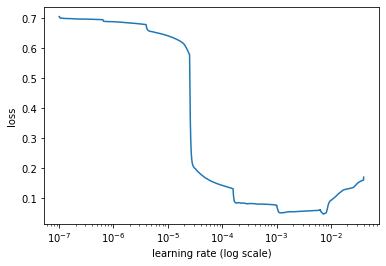

In [25]:
learner.lr_plot()

In [26]:
learningRate = 0.001
numEpoch = 3

learner.fit_onecycle(learningRate, numEpoch)
#learner.autofit(learningRate, numEpoch)
ktrain.get_predictor(model, preproc).save('/content/drive/MyDrive/bigru_yelp_predictor')



begin training using onecycle policy with max lr of 0.001...
Epoch 1/3
2750/2750 [==============================] - 81s 29ms/step - loss: 0.1478 - accuracy: 0.9358 - val_loss: 0.0629 - val_accuracy: 0.9773
Epoch 2/3
2750/2750 [==============================] - 76s 28ms/step - loss: 0.0510 - accuracy: 0.9821 - val_loss: 0.0515 - val_accuracy: 0.9816
Epoch 3/3
2750/2750 [==============================] - 77s 28ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0535 - val_accuracy: 0.9822


In [27]:
# # reload Predictor and extract model
# model = ktrain.load_predictor('/content/drive/MyDrive/bert_yelp_predictor').model

# # re-instantiate Learner and continue training
# learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=batchSize)
# #learner.fit_onecycle(learningRate, numEpoch)
# learner.autofit(learningRate, numEpoch)
# ktrain.get_predictor(model, preproc).save('/content/drive/MyDrive/bert_yelp_predictor')

In [28]:
# learningRate = 0.001
# numEpoch = 3

# # learner.fit_onecycle(learningRate, numEpoch)
# learner.autofit(learningRate, numEpoch)

In [29]:
learner.validate(val_data=(x_test, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     37704
           1       0.98      0.98      0.98     37714

    accuracy                           0.98     75418
   macro avg       0.98      0.98      0.98     75418
weighted avg       0.98      0.98      0.98     75418



array([[37067,   637],
       [  709, 37005]])